In [1]:
import collections
import os
import torch
import torch
from d2l import torch as d2l

机器翻译正是将输入序列转换成输出序列的 序列转换模型（sequence transduction）的核心问题

In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')
#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

#@save
def preprocess_nmt(text):
    """ 数据集预处理 """
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [3]:
# 词元化
#@save
def tokenize_nmt(text, num_examps=None):
    """ 数据集词元化 """
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examps and i > num_examps:
            break
        parts = line.split('\t')
        if len(parts) == 2:
                source.append(parts[0].split(' '))
                target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

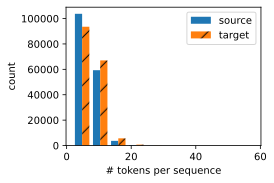

In [4]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

In [5]:
class Vocab:  #@save
    """ 文本列表 """
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = self.counter_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx 
                             for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                # 已经排好序了，直接break
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        
        return [self.idx_to_token[index] for index in indices]
    
    def counter_corpus(self, tokens):  #@save
        """ 统计词元的概率 """
        if len(tokens) == 0 or isinstance(tokens[0], list):
            # 展开token，成为一个list
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)
    
    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

In [6]:
src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [7]:
print(src_vocab['?'])
print(src_vocab['who'])
print(src_vocab['!'])
print(src_vocab['.'])


9
90
126
4


In [8]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """ 截断或填充文本序列 """
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """ 将机器翻译的文本序列转为小批量 """
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines]) 
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [10]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """ 返回翻译数据集的迭代器和词表 """
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>']) 
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size) 
    return data_iter, src_vocab, tgt_vocab

In [11]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 40,   0,   5,   3,   1,   1,   1,   1],
        [115,   5,   3,   1,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 3])
Y: tensor([[ 52,  13, 170,   5,   3,   1,   1,   1],
        [ 65,   5,   3,   1,   1,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([5, 3])


# 编码器-解码器架构
机器翻译是序列转换模型的一个核心问题， 其输入和输出都是长度可变的序列。 为了处理这种类型的输入和输出， 我们可以设计一个包含两个主要组件的架构： 第一个组件是一个编码器（encoder）： 它接受一个长度可变的序列作为输入， 并将其转换为具有固定形状的编码状态。 第二个组件是解码器（decoder）： 它将固定形状的编码状态映射到长度可变的序列。 这被称为编码器-解码器（encoder-decoder）架构

In [12]:
from torch import nn

In [13]:
#@save
class Encoder(nn.Module):
    """ 编码器-解码器的基本编码器接口 """
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
    def forward(self, X, *args):
        raise NotImplementedError

In [14]:
#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [15]:
#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [23]:
#@save
class Seq2SeqEncoder(Encoder):
    """ 用于序列到序列学习的循环神经网络编码器 """
    def __init__(self, vocab_size, embed_size, num_hiddens, 
                 num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, 
                           num_layers, dropout=dropout)
        
    def forward(self, X, *args):
        """前向推理：
        
        X的形状：(num_steps, batch_size, vocab_size)
        output的形状:(num_steps,batch_size,num_hiddens)
        state的形状:(num_layers,batch_size,num_hiddens)
        """
        X = self.embedding(X)  # X.shape: (batch_size, num_steps, embed_size)
        X = X.permute(1, 0, 2)  # 在循环神经网络模型中，第一个轴对应于时间步
        output, state = self.rnn(X)  # 如果未提及状态，默认为0
        return output, state

In [24]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4 ,7), dtype=torch.long)
output,state = encoder(X)
print(output.shape)
print(state.shape)

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


In [31]:
class Seq2SeqDecoder(Decoder):
    """ 用于序列到粗肋学习的循环神经网络编码器 """
    def __init__(self, vocab_size, embed_size, num_hiddens, 
                 num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, 
                          num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        """
        
        X的形状：
        output的形状:(batch_size,num_steps,vocab_size)
        state的形状:(num_layers,batch_size,num_hiddens)
        
        """
        X = self.embedding(X)  # X.shape: (batch_size, num_steps, embed_size)
        X = X.permute(1, 0, 2)  # 在循环神经网络模型中，第一个轴对应于时间步
        context = state[-1].repeat(X.shape[0], 1, 1) # 广播context使其与X有相同的num_steps
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [32]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, 
                         num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [34]:
#@save
def sequence_mask(X, valid_len, value=0):
    """ 在序列中屏蔽不相关的项 """
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [42]:
a = torch.arange((10), dtype=torch.float32,
                        )
print(a.shape)
print(a[None, :].shape)

c = torch.tensor([1, 2])
print(c[:, None])

torch.Size([10])
torch.Size([1, 10])
tensor([[1],
        [2]])


In [43]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。 最初，所有预测词元的掩码都设置为1。 一旦给定了有效长度，与填充词元对应的掩码将被设置为0。 最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [47]:
#@save 
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """ 带遮蔽的softmax交叉熵损失函数 """
    def forward(self, pred, label, valid_len):
        """
        pred的形状：(batch_size,num_steps,vocab_size)
        label的形状：(batch_size,num_steps)
        valid_len的形状：(batch_size,)
        """
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [48]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [58]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """ 训练序列到序列模型 """
    def xavier_init_weights(layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight)
        
        if type(layer) == nn.GRU:
            for param in layer._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(layer._parameters[param])
                    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.019, 15386.9 tokens/sec on cuda:0


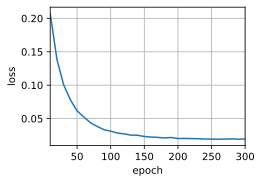

In [59]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

为了采用一个接着一个词元的方式预测输出序列， 每个解码器当前时间步的输入都将来自于前一时间步的预测词元。 与训练类似，序列开始词元（“<bos>”） 在初始时间步被输入到解码器中,当输出序列的预测遇到序列结束词元（“<eos>”）时，预测就结束了。

In [67]:
import math

In [68]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """ 序列到序列模型的预测 """
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<pad>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [69]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [70]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va <unk> !, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> ., bleu 0.658
i'm home . => je suis chez moi partie ., bleu 0.803
